In [2]:
import pandas as pd
import os 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
%matplotlib inline

In [17]:
#keras dependencies
from keras.models import Model
from keras.layers import Input,Dense
from keras.layers import LSTM
import tensorflow as tf
import keras
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate
from keras.layers import Bidirectional
from keras.layers import TimeDistributed, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint


Load in inputs

In [5]:
X_s = np.load('Xs_window_100.npy')
y_s = np.load('Ys_window_100.npy')
X_s.shape,y_s.shape

((39680, 100, 35), (39680, 100, 1))

Recall Class Weights

In [6]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_s.flatten()),
                                                 y_s.flatten())
class_weights = dict(zip(np.unique(y_s.flatten()),class_weights))
class_weights

{0.0: 0.5319462691369279, 1.0: 8.325639949643307}

Shuffle

In [7]:
from sklearn.utils import shuffle
X_s,y_s = shuffle(X_s,y_s)

In [25]:
def create_LSTM_model(units=3, rows=100,cols=35):
    # define model
    inputs1 = Input(shape=(rows, cols))
    lstm1, state_h, state_c = LSTM(units, return_sequences=True, return_state=True)(inputs1)
    hidden_state_preds = Dense(1,activation='sigmoid',name='dense_1')(lstm1)
    last_step_preds = Dense(1,activation='sigmoid',name='dense_2')(state_h)
    model = Model(inputs=inputs1, outputs=[hidden_state_preds,last_step_preds])
    return model
model = create_LSTM_model()
output = model.predict(X_s[41,:,:].reshape((1,100,35)))
print(output)

[array([[[0.5       ],
        [0.5       ],
        [0.47713014],
        [0.42390424],
        [0.5       ],
        [0.24807641],
        [0.5       ],
        [0.5       ],
        [0.48230603],
        [0.25430834],
        [0.4588678 ],
        [0.42390424],
        [0.42390424],
        [0.31669584],
        [0.38870165],
        [0.4082429 ],
        [0.42390424],
        [0.5       ],
        [0.5757173 ],
        [0.5       ],
        [0.4599601 ],
        [0.31669584],
        [0.25371087],
        [0.25430834],
        [0.31669584],
        [0.44143763],
        [0.2742034 ],
        [0.26801273],
        [0.21223676],
        [0.26801273],
        [0.24016902],
        [0.23400828],
        [0.21151605],
        [0.21141842],
        [0.26705194],
        [0.26407075],
        [0.21140516],
        [0.23404387],
        [0.22045454],
        [0.42390424],
        [0.42390424],
        [0.31669584],
        [0.44499427],
        [0.39056873],
        [0.29974213],
        [

In [26]:
# compile the model
model.compile(
    loss=keras.losses.binary_crossentropy,
    optimizer=keras.optimizers.Adam(lr=0.00001),
    metrics=["accuracy"],
)

#callbacks
mcp_save_train_hidden_states = ModelCheckpoint('LSTM_hiddenstates_v1.h5', 
                                               save_best_only=True, 
                                               monitor='val_dense_1_loss', 
                                               mode='min')
mcp_save_train_final_output = ModelCheckpoint('LSTM_finaloutput_v1.h5', 
                                              save_best_only=True, 
                                              monitor='val_dense_2_loss', 
                                              mode='min')

# keep track of the results
history = model.fit(X_s,
                    [y_s.reshape((39680,100,1)),y_s[:,-1]], 
                    batch_size=32,
                    class_weight = class_weights,
                    validation_split = 0.1,
                    callbacks=[mcp_save_train_hidden_states,mcp_save_train_final_output],
                    epochs=60)

Train on 35712 samples, validate on 3968 samples
Epoch 1/60
35712/35712 [==============================] - 247s 7ms/step - loss: 1.4025 - dense_1_loss: 0.4853 - dense_2_loss: 0.9172 - dense_1_acc: 0.8621 - dense_2_acc: 0.2086 - val_loss: 1.3680 - val_dense_1_loss: 0.4649 - val_dense_2_loss: 0.9031 - val_dense_1_acc: 0.8666 - val_dense_2_acc: 0.2107
Epoch 2/60
35712/35712 [==============================] - 240s 7ms/step - loss: 1.3334 - dense_1_loss: 0.4551 - dense_2_loss: 0.8783 - dense_1_acc: 0.8724 - dense_2_acc: 0.2145 - val_loss: 1.2930 - val_dense_1_loss: 0.4430 - val_dense_2_loss: 0.8500 - val_dense_1_acc: 0.8760 - val_dense_2_acc: 0.2238
Epoch 3/60
35712/35712 [==============================] - 233s 7ms/step - loss: 1.2497 - dense_1_loss: 0.4416 - dense_2_loss: 0.8081 - dense_1_acc: 0.8806 - dense_2_acc: 0.2321 - val_loss: 1.2005 - val_dense_1_loss: 0.4399 - val_dense_2_loss: 0.7607 - val_dense_1_acc: 0.8828 - val_dense_2_acc: 0.2671
Epoch 4/60
35712/35712 [=====================

35712/35712 [==============================] - 231s 6ms/step - loss: 0.6868 - dense_1_loss: 0.2731 - dense_2_loss: 0.4138 - dense_1_acc: 0.9360 - dense_2_acc: 0.9323 - val_loss: 0.6761 - val_dense_1_loss: 0.2711 - val_dense_2_loss: 0.4050 - val_dense_1_acc: 0.9366 - val_dense_2_acc: 0.9390
Epoch 28/60
35712/35712 [==============================] - 278s 8ms/step - loss: 0.6753 - dense_1_loss: 0.2698 - dense_2_loss: 0.4055 - dense_1_acc: 0.9367 - dense_2_acc: 0.9339 - val_loss: 0.6648 - val_dense_1_loss: 0.2680 - val_dense_2_loss: 0.3968 - val_dense_1_acc: 0.9370 - val_dense_2_acc: 0.9400
Epoch 29/60
35712/35712 [==============================] - 305s 9ms/step - loss: 0.6642 - dense_1_loss: 0.2667 - dense_2_loss: 0.3975 - dense_1_acc: 0.9369 - dense_2_acc: 0.9349 - val_loss: 0.6537 - val_dense_1_loss: 0.2651 - val_dense_2_loss: 0.3887 - val_dense_1_acc: 0.9372 - val_dense_2_acc: 0.9403
Epoch 30/60
35712/35712 [==============================] - 311s 9ms/step - loss: 0.6535 - dense_1_loss:

35712/35712 [==============================] - 235s 7ms/step - loss: 0.4957 - dense_1_loss: 0.2329 - dense_2_loss: 0.2627 - dense_1_acc: 0.9395 - dense_2_acc: 0.9420 - val_loss: 0.4850 - val_dense_1_loss: 0.2326 - val_dense_2_loss: 0.2524 - val_dense_1_acc: 0.9398 - val_dense_2_acc: 0.9473
Epoch 55/60
35712/35712 [==============================] - 231s 6ms/step - loss: 0.4923 - dense_1_loss: 0.2327 - dense_2_loss: 0.2596 - dense_1_acc: 0.9395 - dense_2_acc: 0.9423 - val_loss: 0.4815 - val_dense_1_loss: 0.2323 - val_dense_2_loss: 0.2491 - val_dense_1_acc: 0.9399 - val_dense_2_acc: 0.9481
Epoch 56/60
35712/35712 [==============================] - 283s 8ms/step - loss: 0.4891 - dense_1_loss: 0.2325 - dense_2_loss: 0.2567 - dense_1_acc: 0.9396 - dense_2_acc: 0.9427 - val_loss: 0.4782 - val_dense_1_loss: 0.2321 - val_dense_2_loss: 0.2461 - val_dense_1_acc: 0.9399 - val_dense_2_acc: 0.9488
Epoch 57/60
35712/35712 [==============================] - 293s 8ms/step - loss: 0.4861 - dense_1_loss:

https://keras.io/api/models/model_training_apis/

In [28]:
history.history.keys()

dict_keys(['val_loss', 'val_dense_1_loss', 'val_dense_2_loss', 'val_dense_1_acc', 'val_dense_2_acc', 'loss', 'dense_1_loss', 'dense_2_loss', 'dense_1_acc', 'dense_2_acc'])

In [14]:
model.layers[2]

In [31]:
output = model.predict(X_s[4036,:,:].reshape((1,100,35)))
print(output)

[array([[[0.08904704],
        [0.0582726 ],
        [0.054618  ],
        [0.05410081],
        [0.05368221],
        [0.05396965],
        [0.0537971 ],
        [0.05396828],
        [0.05388254],
        [0.05380437],
        [0.05370596],
        [0.05388525],
        [0.05396828],
        [0.05395889],
        [0.05396828],
        [0.05395159],
        [0.05396828],
        [0.05374312],
        [0.05391181],
        [0.05371225],
        [0.05396828],
        [0.05396828],
        [0.05403957],
        [0.05396828],
        [0.05395669],
        [0.05394271],
        [0.05396828],
        [0.05392191],
        [0.05396828],
        [0.05396828],
        [0.05393925],
        [0.05396828],
        [0.05392018],
        [0.05401871],
        [0.05396828],
        [0.05396876],
        [0.05385929],
        [0.05385146],
        [0.05396828],
        [0.0539335 ],
        [0.05396828],
        [0.05372092],
        [0.05391529],
        [0.05396828],
        [0.05396345],
        [

In [41]:
metric.to_csv('Log_files_v1.csv')

In [38]:
metric = pd.DataFrame(history.history)
metric.head()

,val_loss,val_dense_1_loss,val_dense_2_loss,val_dense_1_acc,val_dense_2_acc,loss,dense_1_loss,dense_2_loss,dense_1_acc,dense_2_acc
0,1.368028,0.464902,0.903126,0.866583,0.210685,1.402499,0.485311,0.917188,0.862058,0.208557
1,1.292984,0.443024,0.849960,0.875950,0.223790,1.333449,0.455144,0.878305,0.872406,0.214550
2,1.200521,0.439853,0.760668,0.882795,0.267137,1.249684,0.441596,0.808088,0.880635,0.232051
3,1.155305,0.431350,0.723955,0.889824,0.658014,1.177385,0.436436,0.740948,0.887988,0.536374
4,1.122336,0.421766,0.700571,0.894970,0.727823,1.140663,0.427099,0.713564,0.893563,0.682516


In [44]:
col_pairs = [(metric.columns[i],metric.columns[i+5]) for i in range(0,5)]

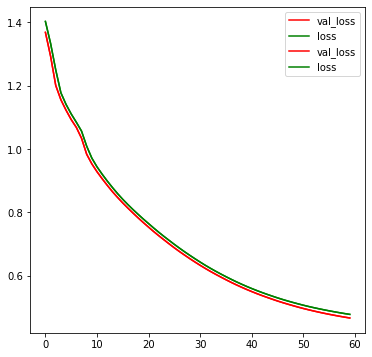

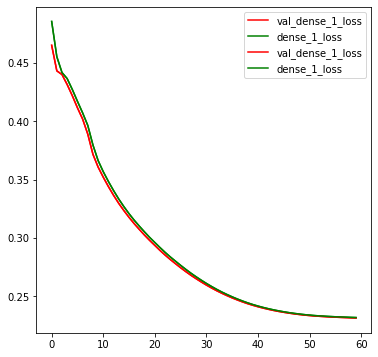

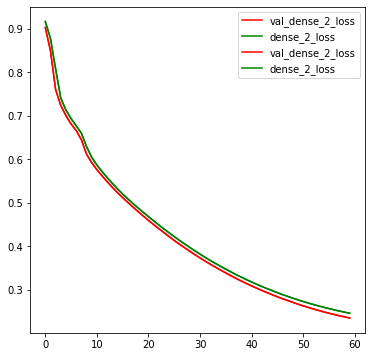

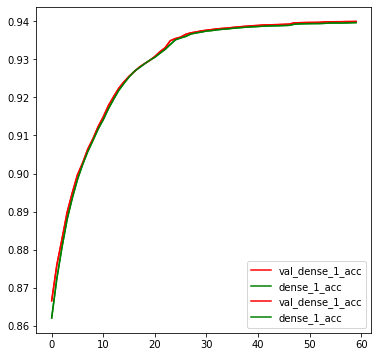

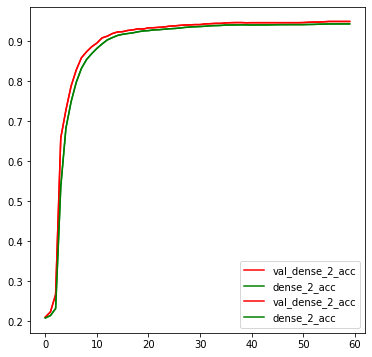

In [61]:
for foo in col_pairs:
    plt.figure(figsize=(6,6))
    for i in range(0,len(foo)):
        plt.plot(metric.index,metric[foo[0]],color='red',label=foo[0])
        plt.plot(metric.index,metric[foo[1]],color='green',label=foo[1])
        plt.legend()
    plt.show()
    

In [54]:
for foo in col_pairs:
    print(foo[0])

val_loss
val_dense_1_loss
val_dense_2_loss
val_dense_1_acc
val_dense_2_acc


AttributeError: 'Line2D' object has no property 'col'

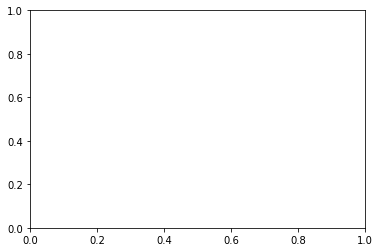

In [58]:
plt.plot(metric.index,metric[foo[0]],col='red',label=foo[0])
#plt.plot(metric.index,metric[foo[1]],col='green',label=foo[1])